In [57]:
### import libraries
import pandas as pd
import numpy as np
import os as os
import datetime as dt
import matplotlib.pyplot as plt
import time
%matplotlib inline
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.cross_validation import train_test_split
import re
from PyDictionary import PyDictionary
dictionary=PyDictionary()

In [31]:
#Set working directory
os.chdir("/Users/halliebregman/Dropbox/Kaggle")

In [32]:
#Load in data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
prod = pd.read_csv("product_descriptions.csv")
sample = pd.read_csv("sample_submission.csv")

In [33]:
#Check out first 5 lines
print train.head()

   id  product_uid                                      product_title  \
0   2       100001                  Simpson Strong-Tie 12-Gauge Angle   
1   3       100001                  Simpson Strong-Tie 12-Gauge Angle   
2   9       100002  BEHR Premium Textured DeckOver 1-gal. #SC-141 ...   
3  16       100005  Delta Vero 1-Handle Shower Only Faucet Trim Ki...   
4  17       100005  Delta Vero 1-Handle Shower Only Faucet Trim Ki...   

          search_term  relevance  
0       angle bracket       3.00  
1           l bracket       2.50  
2           deck over       3.00  
3    rain shower head       2.33  
4  shower only faucet       2.67  


In [34]:
#Merge train and product descriptions
train = pd.DataFrame.merge(train, prod, on="product_uid", how='left')

In [35]:
#Merge test and product descriptions
test = pd.DataFrame.merge(test, prod, on="product_uid", how='left')

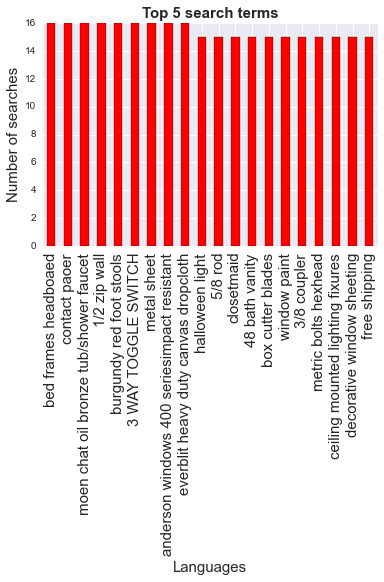

In [36]:
###Look at most common search terms
search = train['search_term'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Languages', fontsize=15)
ax.set_ylabel('Number of searches' , fontsize=15)
#ax.set_y_axis(0, 30)
ax.set_title('Top 5 search terms', fontsize=15, fontweight='bold')
search[:20].plot(ax=ax, kind='bar', color='red')

In [37]:
#Concatenate train and test
frames= [train, test]
df_all = pd.concat(frames, keys=['train', 'test'])

In [38]:
#Preprocess text
def cleantext(string):
    #Lowercase all text
    string = string.lower()
    #replace variations on inch
    string = string.replace(" in.", "in.").replace(" inch","in.").replace("inch","in.").replace(" in ","in. ")
    #remove * from starting characters
    string = string.lstrip('*')
    return string

In [39]:
#Clean text
df_all['search_term'] = df_all['search_term'].map(lambda x:cleantext(x))
df_all['product_title'] = df_all['product_title'].map(lambda x:cleantext(x))
df_all['product_description'] = df_all['product_description'].map(lambda x:cleantext(x))

In [40]:
#Calculate length of text
df_all['len_of_query'] = df_all['search_term'].map(lambda x:len(x.split())).astype(np.int64)
df_all['len_of_title'] = df_all['product_title'].map(lambda x:len(x.split())).astype(np.int64)
df_all['len_of_description'] = df_all['product_description'].map(lambda x:len(x.split())).astype(np.int64)

                    len_of_query  len_of_title  len_of_description  relevance
len_of_query            1.000000      0.144819            0.067768  -0.073189
len_of_title            0.144819      1.000000            0.311224  -0.019840
len_of_description      0.067768      0.311224            1.000000   0.040001
relevance              -0.073189     -0.019840            0.040001   1.000000


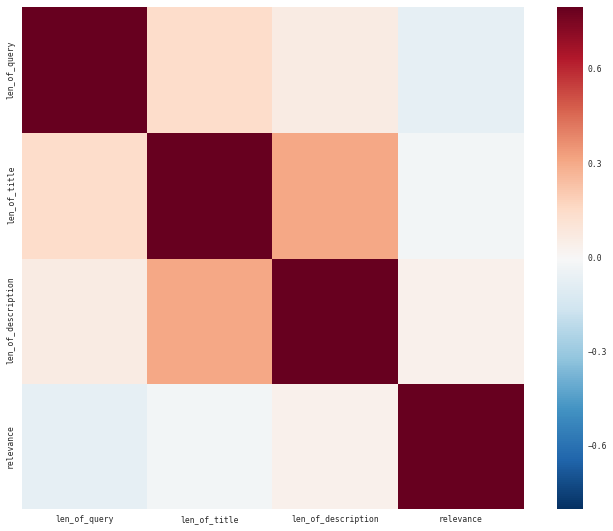

In [41]:
sns.set(context="paper", font="monospace")

#Subset 
sub = df_all[['len_of_query', 'len_of_title', 'len_of_description', 'relevance']]
#Calculate correlation
corrmat = sub.corr()
print corrmat

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)

In [42]:
#Function to count common number of words in two strings
def str_common_word(str1, str2):
    words, cnt = str1.split(), 0
    for word in words:
        if str2.find(word)>=0:
            cnt+=1
    return cnt

In [43]:
#Concatenate product information
df_all['product_info'] = df_all['search_term']+"\t"+df_all['product_title'] +"\t"+df_all['product_description']
#Count how many common words are in the search query and title
df_all['word_in_title'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]))
#Count how many common words are in the search query and description
df_all['word_in_description'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[2]))

In [44]:
#Function to count number of times who query is in string
def str_whole_word(str1, str2, i_):
    str1, str2 = str1.strip(), str2.strip()
    cnt = 0
    while i_ < len(str2):
        i_ = str2.find(str1, i_)
        if i_ == -1:
            return cnt
        else:
            cnt += 1
            i_ += len(str1)
    return cnt

In [45]:
##Count how many times the whole query is in the title
df_all['query_in_title'] = df_all['product_info'].map(lambda x:str_whole_word(x.split('\t')[0],x.split('\t')[1],0))
#Count how many times the whole search query is in the description
df_all['query_in_description'] = df_all['product_info'].map(lambda x:str_whole_word(x.split('\t')[0],x.split('\t')[2],0))

                      relevance  len_of_query  len_of_title  \
relevance              1.000000     -0.073189     -0.019840   
len_of_query          -0.073189      1.000000      0.144819   
len_of_title          -0.019840      0.144819      1.000000   
len_of_description     0.040001      0.067768      0.311224   
query_in_title         0.148050     -0.323501     -0.049220   
query_in_description   0.073741     -0.122344     -0.025662   
word_in_title          0.182848      0.625241      0.203934   
word_in_description    0.142910      0.646425      0.117554   

                      len_of_description  query_in_title  \
relevance                       0.040001        0.148050   
len_of_query                    0.067768       -0.323501   
len_of_title                    0.311224       -0.049220   
len_of_description              1.000000       -0.042520   
query_in_title                 -0.042520        1.000000   
query_in_description            0.018357        0.377510   
word_in_titl

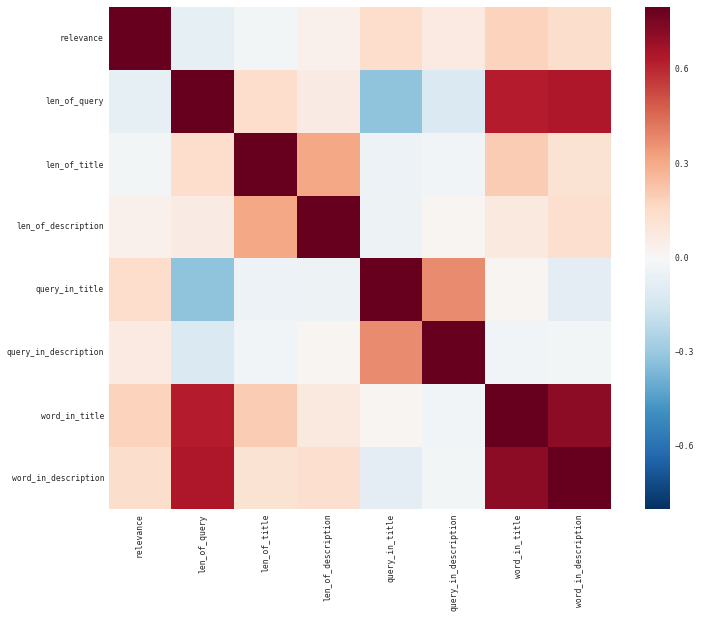

In [46]:
sns.set(context="paper", font="monospace")

#Subset 
sub = df_all[['relevance', 'len_of_query', 'len_of_title', 'len_of_description', 'query_in_title', 'query_in_description', 'word_in_title', 'word_in_description']]
#Calculate correlation
corrmat = sub.corr()
print corrmat

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)

In [55]:
#Function to find synonyms for search terms- Work in progress!
def str_synonyms(string):
    newstring = ''
    for word in string.split():
        newstring += str(dictionary.synonym(word))
        newstring = ','.join(newstring.split())
    return newstring

def str_synonyms(string):
    newstring_list = []
    for word in string.split():
        if dictionary.synonym(word):
            newstring_list.extend(dictionary.synonym(word))
    newstring = ', '.join(newstring_list)  
    return newstring

In [65]:
#Apply synonym function
df_all['search_syns'] = df_all['search_term'].map(lambda x:str_synonyms(x))

3/4 has no Synonyms in the API
& has no Synonyms in the API
& has no Synonyms in the API
8 has no Synonyms in the API
9 has no Synonyms in the API
6 has no Synonyms in the API
3 has no Synonyms in the API
6 has no Synonyms in the API
6 has no Synonyms in the API
elastomeric has no Synonyms in the API
6 has no Synonyms in the API
3 has no Synonyms in the API
5 has no Synonyms in the API
2 has no Synonyms in the API
5 has no Synonyms in the API
4 has no Synonyms in the API
greecianmarble has no Synonyms in the API
3 has no Synonyms in the API
3 has no Synonyms in the API
& has no Synonyms in the API
$100 has no Synonyms in the API
3/4 has no Synonyms in the API
2 has no Synonyms in the API
photoelectric/ion has no Synonyms in the API
* has no Synonyms in the API
8 has no Synonyms in the API
cordlessrotary has no Synonyms in the API
2 has no Synonyms in the API
3/4 has no Synonyms in the API
4 has no Synonyms in the API
4 has no Synonyms in the API
2 has no Synonyms in the API
3/4 has no 

TypeError: 'NoneType' object is not iterable

In [ ]:
df_all['product_syns'] = df_all['search_syns']+"\t"+df_all['product_title'] +"\t"+df_all['product_description']
#Count how many common words are in the search query and title
df_all['syns_in_title'] = df_all['product_syns'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]))
#Count how many common words are in the search query and description
df_all['syns_in_description'] = df_all['product_syns'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[2]))

In [66]:
#Separate test and train
train = df_all.loc['train']
test = df_all.loc['test']

In [67]:
#Column names
df_all.columns.values

array(['id', 'product_description', 'product_title', 'product_uid',
       'relevance', 'search_term', 'len_of_query', 'len_of_title',
       'len_of_description', 'product_info', 'word_in_title',
       'word_in_description', 'query_in_title', 'query_in_description'], dtype=object)

In [68]:
#Define X and y for test and train
X = train[['len_of_query', 'len_of_title',
       'len_of_description', 'word_in_title',
       'word_in_description', 'query_in_title', 'query_in_description']]
y = train[['relevance']]
y = np.squeeze(y)

Xt = test[['len_of_query', 'len_of_title',
       'len_of_description', 'word_in_title',
       'word_in_description', 'query_in_title', 'query_in_description']]
yt = test[['relevance']]
yt = np.squeeze(yt)

# use train/test split with different random_state values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)

In [72]:
# define the parameter values that should be searched
knn = RandomForestRegressor()
k_range = range(1, 31)
weight_options = ['auto', 'log2', 'sqrt']
depth = range(1, 30)

# create a parameter grid: map the parameter names to the values that should be searched
param_dist = dict(n_estimators=k_range, max_features=weight_options, max_depth= depth)

# run GridSearchCV and record the best score
rand = RandomizedSearchCV(knn, param_dist, scoring='mean_squared_error', cv=10)
rand.fit(X_train, y_train)
print rand.best_params_
print rand.best_score_

{'max_features': 'log2', 'n_estimators': 27, 'max_depth': 13}
-0.246974241299


               features  estimatedCoefficients
6  query_in_description               0.031006
5        query_in_title               0.065338
4   word_in_description               0.099581
1          len_of_title               0.133697
3         word_in_title               0.188911
0          len_of_query               0.217586
2    len_of_description               0.263881


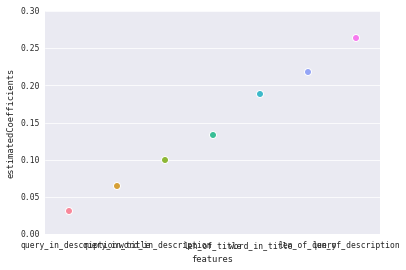

In [73]:
knn = RandomForestRegressor(n_estimators=27, max_features='log2', max_depth=13)
knn.fit(X_train, y_train)

#Bind feature importance
coefs = pd.DataFrame(zip(X.columns, knn.feature_importances_), columns=['features', 'estimatedCoefficients'])
print coefs.sort('estimatedCoefficients')

#Plot feature importance
sns.stripplot(x="features", y="estimatedCoefficients", data=coefs.sort('estimatedCoefficients'));

In [74]:
# predict the response for new observations
knn.fit(X, y)
test['relevance'] = knn.predict(Xt)

/Users/halliebregman/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [ ]:
pd.DataFrame({"id": test['id'], "relevance": test['relevance']}).to_csv('submission.csv',index=False)